# Wasserstein GAN (WGAN)

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import pathlib
import zipfile
import torch
import sys
import pandas as pd

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms.functional as F


from skimage import io, transform

from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

2025-04-25 19:20:29.687702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 19:20:29.694334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745601629.702028   70053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745601629.704349   70053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 19:20:29.712890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Device Mode

In [2]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Generator

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.gen = nn.Sequential(

            self.get_generator_block(z_dim,
                                     hidden_dim * 4,
                                     kernel_size=3,
                                     stride=2),

            self.get_generator_block(hidden_dim * 4,
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),

            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),

            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)


        )


    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )


    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )


    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)



summary(Generator(100).to(device), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Critic / Discriminator

In [4]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),

            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),

            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )


    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )


    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )

    def forward(self, image):
        return self.disc(image)

summary(Critic().to(device) , (1,28,28))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2,

# Noise Creator Function

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

# MNIST Dataset Load

In [6]:
z_dim = 100
batch_size = 128

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

# Loaded Data Visualization

Time is 0.004626274108886719 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


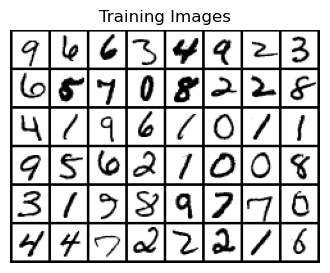

In [7]:
start = time.time()
dataiter = iter(dataloader)
images,labels = next(dataiter)
print ('Time is {} sec'.format(time.time()-start))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
inverted_images = F.invert(images[0:48])
plt.imshow(np.transpose(make_grid(inverted_images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

# Optimizer

In [8]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [9]:
# test = get_noise(batch_size, z_dim, device=device)
# test_gan = gen(test)
# grid_img = np.transpose(make_grid(test_gan[0].to(device), padding=2, normalize=True).cpu().detach(),(1,2,0))

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(grid_img)

# Gradient Penalty

In [10]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

# Loss

In [11]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [12]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

# Model Training Process

In [13]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,

    )[0]
    return gradient

In [14]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    inverted_images = F.invert(image_unflat[0:num_images])
    image_grid = make_grid(inverted_images, nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    plt.show()

Epoch: 0/15 Steps:469/469	Epoch_Run_Time: 14.456880	Loss_C : -42.654797	Loss_G : 1.805114		
Epoch: 0/15 Total Steps:469	Total_Time : 14.457613	Loss_C : -42.654797	Loss_G : 1.805114	Loss_C_Mean : -17.757605	Loss_G_Mean : 0.225952	


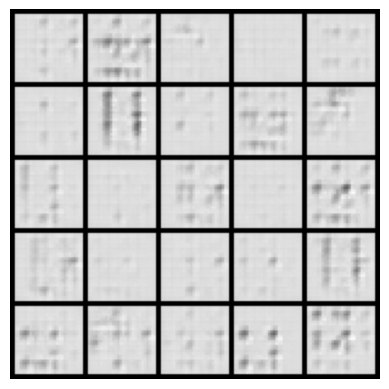

Epoch: 1/15 Steps:469/469	Epoch_Run_Time: 14.313920	Loss_C : 28.167302	Loss_G : 8.089992			

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5677391].



Epoch: 1/15 Total Steps:938	Total_Time : 28.819193	Loss_C : 28.167302	Loss_G : 8.089992	Loss_C_Mean : -56.135106	Loss_G_Mean : 0.196208	


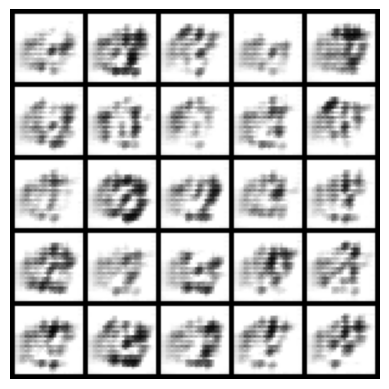

Epoch: 2/15 Steps:469/469	Epoch_Run_Time: 14.280278	Loss_C : -98.136606	Loss_G : 23.860548		

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2116413].



Epoch: 2/15 Total Steps:1407	Total_Time : 43.144243	Loss_C : -98.136606	Loss_G : 23.860548	Loss_C_Mean : -87.877409	Loss_G_Mean : 13.200632	


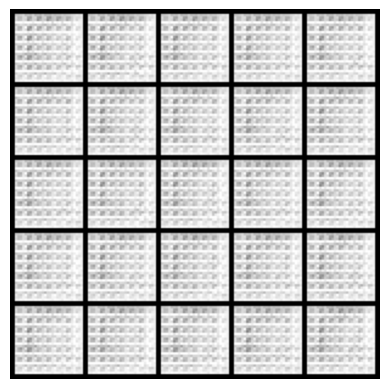

Epoch: 3/15 Steps:469/469	Epoch_Run_Time: 14.384649	Loss_C : -90.054802	Loss_G : 18.587128		

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4891902].



Epoch: 3/15 Total Steps:1876	Total_Time : 57.581836	Loss_C : -90.054802	Loss_G : 18.587128	Loss_C_Mean : -99.190743	Loss_G_Mean : 22.362206	


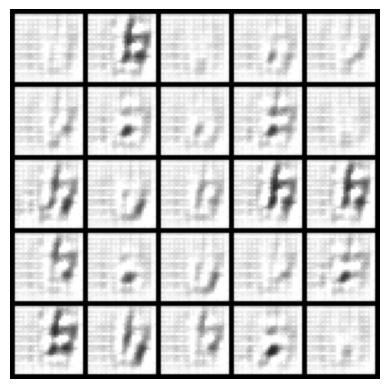

Epoch: 4/15 Steps:469/469	Epoch_Run_Time: 14.395089	Loss_C : -122.644380	Loss_G : 15.650142	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3355932].



Epoch: 4/15 Total Steps:2345	Total_Time : 72.027654	Loss_C : -122.644380	Loss_G : 15.650142	Loss_C_Mean : -95.363839	Loss_G_Mean : 17.501894	


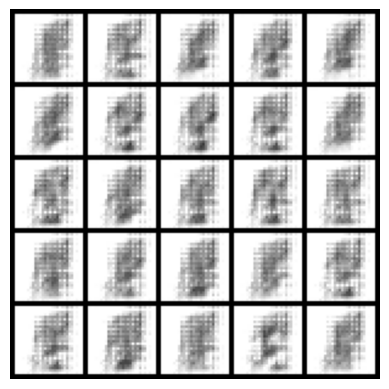

Epoch: 5/15 Steps:469/469	Epoch_Run_Time: 14.320772	Loss_C : -160.422241	Loss_G : 26.101505	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.403728].



Epoch: 5/15 Total Steps:2814	Total_Time : 86.392401	Loss_C : -160.422241	Loss_G : 26.101505	Loss_C_Mean : -151.482352	Loss_G_Mean : 21.791620	


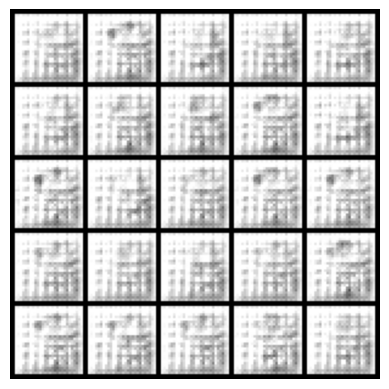

Epoch: 6/15 Steps:469/469	Epoch_Run_Time: 14.329905	Loss_C : -233.788214	Loss_G : 34.202347	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5315642].



Epoch: 6/15 Total Steps:3283	Total_Time : 100.773682	Loss_C : -233.788214	Loss_G : 34.202347	Loss_C_Mean : -186.346116	Loss_G_Mean : 29.575582	


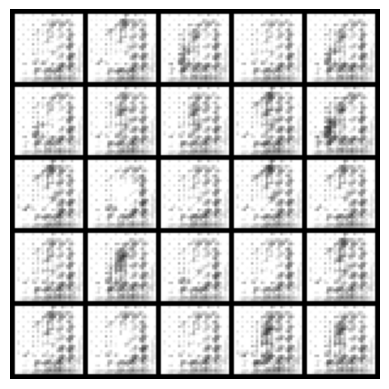

Epoch: 7/15 Steps:469/469	Epoch_Run_Time: 14.296368	Loss_C : -0.395474	Loss_G : 26.181931	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2076029].



Epoch: 7/15 Total Steps:3752	Total_Time : 115.122450	Loss_C : -0.395474	Loss_G : 26.181931	Loss_C_Mean : 2.749117	Loss_G_Mean : 26.204981	


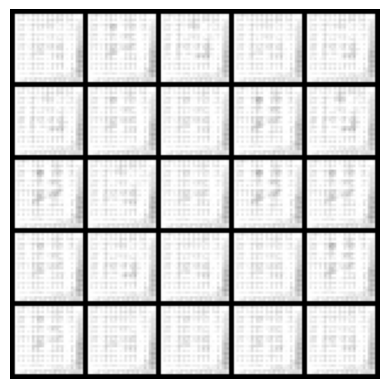

Epoch: 8/15 Steps:469/469	Epoch_Run_Time: 14.339604	Loss_C : -6.439716	Loss_G : 18.780130		

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4681618].



Epoch: 8/15 Total Steps:4221	Total_Time : 129.516995	Loss_C : -6.439716	Loss_G : 18.780130	Loss_C_Mean : -11.734565	Loss_G_Mean : 23.470194	


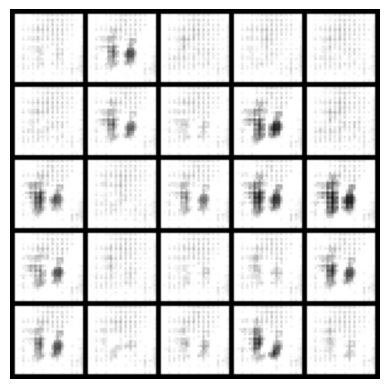

Epoch: 9/15 Steps:469/469	Epoch_Run_Time: 14.346417	Loss_C : -23.594089	Loss_G : 12.133758	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3700038].



Epoch: 9/15 Total Steps:4690	Total_Time : 143.909062	Loss_C : -23.594089	Loss_G : 12.133758	Loss_C_Mean : -19.392579	Loss_G_Mean : 16.646613	


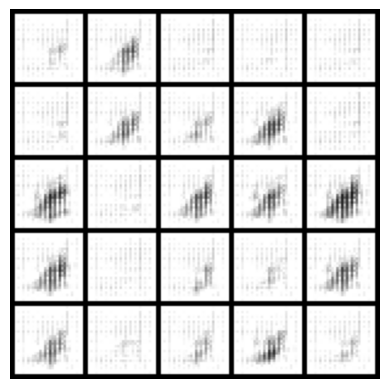

Epoch: 10/15 Steps:469/469	Epoch_Run_Time: 14.380592	Loss_C : -47.709890	Loss_G : 13.850611	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5732421].



Epoch: 10/15 Total Steps:5159	Total_Time : 158.332424	Loss_C : -47.709890	Loss_G : 13.850611	Loss_C_Mean : -34.102797	Loss_G_Mean : 11.946859	


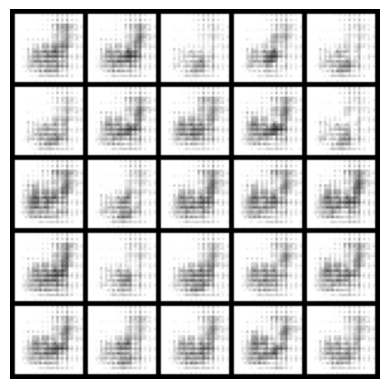

Epoch: 11/15 Steps:469/469	Epoch_Run_Time: 14.328217	Loss_C : 1.721701	Loss_G : 15.821376			

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6240642].



Epoch: 11/15 Total Steps:5628	Total_Time : 172.706789	Loss_C : 1.721701	Loss_G : 15.821376	Loss_C_Mean : -42.545974	Loss_G_Mean : 14.002598	


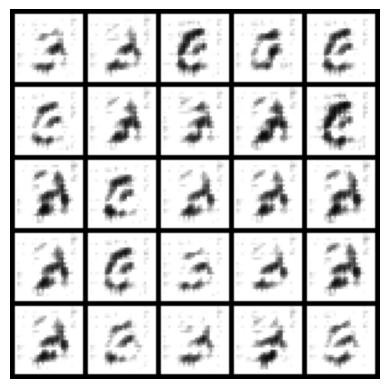

Epoch: 12/15 Steps:469/469	Epoch_Run_Time: 14.287130	Loss_C : -3.522726	Loss_G : 19.436989	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7341276].



Epoch: 12/15 Total Steps:6097	Total_Time : 187.034322	Loss_C : -3.522726	Loss_G : 19.436989	Loss_C_Mean : -2.819694	Loss_G_Mean : 19.075134	


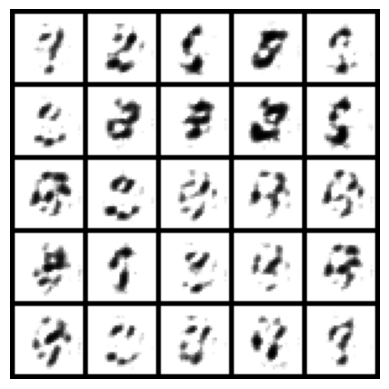

Epoch: 13/15 Steps:469/469	Epoch_Run_Time: 14.410323	Loss_C : -30.321830	Loss_G : 21.094812	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.681438].



Epoch: 13/15 Total Steps:6566	Total_Time : 201.477753	Loss_C : -30.321830	Loss_G : 21.094812	Loss_C_Mean : -13.203820	Loss_G_Mean : 19.956444	


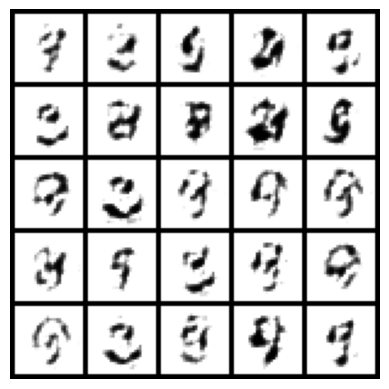

Epoch: 14/15 Steps:469/469	Epoch_Run_Time: 14.321537	Loss_C : -16.135503	Loss_G : 16.511480	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5549513].



Epoch: 14/15 Total Steps:7035	Total_Time : 215.830463	Loss_C : -16.135503	Loss_G : 16.511480	Loss_C_Mean : -18.342101	Loss_G_Mean : 18.137246	


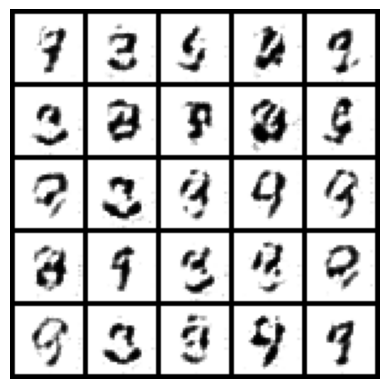

In [15]:
n_epochs = 15
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        cur_step += 1
        total_steps += 1

        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"
        print(print_val, end='\r',flush = True)

        ### Visualization code ###
#         if cur_step % display_step == 0 and cur_step > 0:
#             print()
#             gen_mean = sum(generator_losses[-display_step:]) / display_step
#             crit_mean = sum(critic_losses[-display_step:]) / display_step
#             print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
#             show_tensor_images(fake)
#             show_tensor_images(real)
#             step_bins = 20
#             num_examples = (len(generator_losses) // step_bins) * step_bins
#             plt.plot(
#                 range(num_examples // step_bins),
#                 torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Generator Loss"
#             )
#             plt.plot(
#                 range(num_examples // step_bins),
#                 torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Critic Loss"
#             )
#             plt.legend()
#             plt.show()

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step

    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)

    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)

    fake_noise = fixed_noise
    fake = gen(fake_noise)

    show_tensor_images(fake, show_fig=True,epoch=epoch)

    cur_step = 0


# After Tranning Loss Visualization

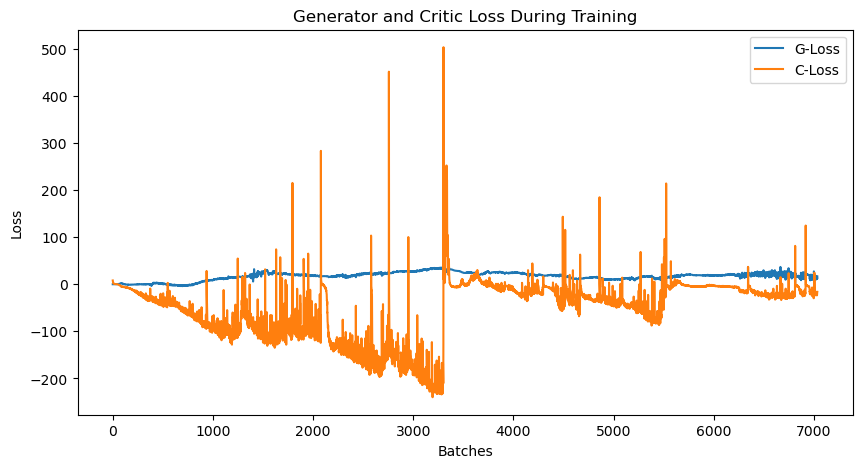

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

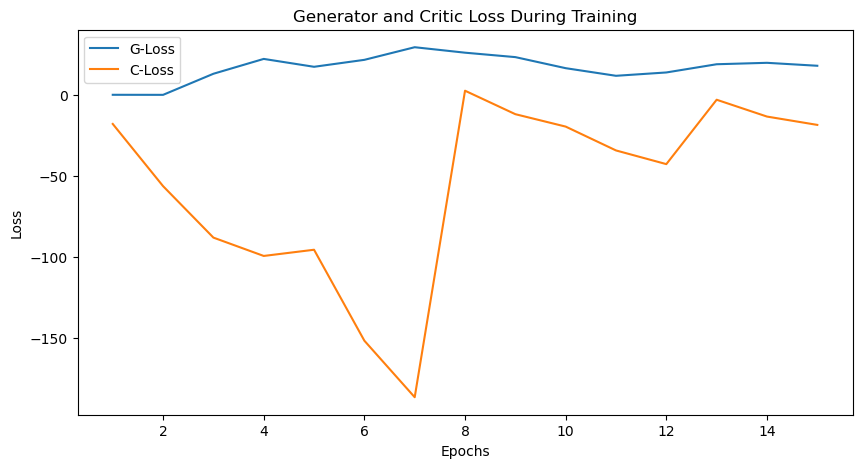

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(range(1,n_epochs+1),G_mean_losses,label="G-Loss")
plt.plot(range(1,n_epochs+1),C_mean_losses,label="C-Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Testing WGAN

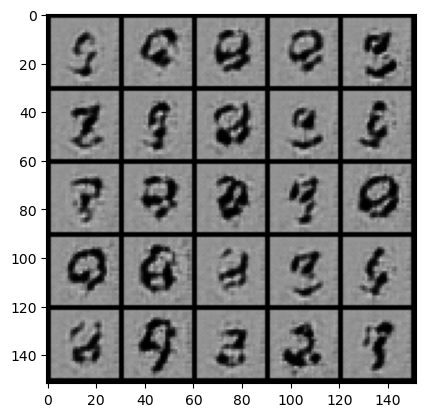

In [18]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    inverted_images = F.invert(unflat_img[0:num_img])
    img_grid = make_grid(inverted_images, nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,1,28,28))